In [1]:
import pandas as pd
import glob
import os

# Path to the datasets folder
path = 'datasets/'
all_files = glob.glob(os.path.join(path, "*.csv"))

print(f"Found {len(all_files)} CSV files.")

li = []
total_rows_expected = 0

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    total_rows_expected += len(df)
    # print(f"Read {filename}: {len(df)} rows") # Optional: detailed logging

# Combine all DataFrames
# sort=False prevents sorting columns if they are not aligned, though concat handles alignment.
frame = pd.concat(li, axis=0, ignore_index=True, sort=False)

print("\n--- Quality Checks ---")
print(f"Total expected rows from individual files: {total_rows_expected}")
print(f"Total rows in combined DataFrame: {len(frame)}")

if len(frame) == total_rows_expected:
    print("SUCCESS: Row count matches.")
else:
    print("WARNING: Row count mismatch!")

print(f"Combined DataFrame shape: {frame.shape}")
print("\nFirst 5 rows:")
print(frame.head())

# Check for missing values if columns mismatched
print("\nMissing values per column (indication of mismatch if high for specific columns):")
print(frame.isnull().sum())

Found 50 CSV files.



--- Quality Checks ---
Total expected rows from individual files: 204329
Total rows in combined DataFrame: 204329
SUCCESS: Row count matches.
Combined DataFrame shape: (204329, 2)

First 5 rows:
             sale_time purchaser_gender
0  2012-10-01 01:42:22           female
1  2012-10-01 02:24:53           female
2  2012-10-01 02:25:40           female
3  2012-10-01 02:30:42           female
4  2012-10-01 02:51:32             male

Missing values per column (indication of mismatch if high for specific columns):
sale_time           0
purchaser_gender    0
dtype: int64


            daily_sales
sale_time              
2012-10-01          514
2012-10-02          482
2012-10-03          499
2012-10-04          546
2012-10-05          476


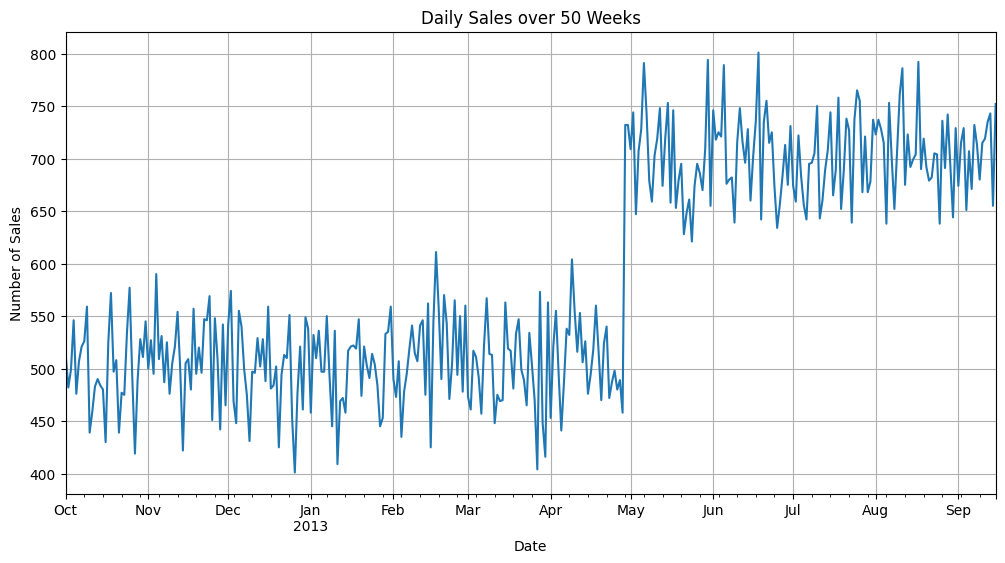

In [2]:
import matplotlib.pyplot as plt

# Convert sale_time to datetime
frame['sale_time'] = pd.to_datetime(frame['sale_time'])

# Aggregate daily sales
daily_sales_df = frame.set_index('sale_time').resample('D').count()

# Rename column for clarity
daily_sales_df = daily_sales_df[['purchaser_gender']].rename(columns={'purchaser_gender': 'daily_sales'})

print(daily_sales_df.head())

# Plot
plt.figure(figsize=(12, 6))
daily_sales_df['daily_sales'].plot()
plt.title('Daily Sales over 50 Weeks')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.grid(True)
plt.show()

In [3]:
# Filter for specific date range
start_date = '2013-04-20'
end_date = '2013-05-10'
filtered_sales = daily_sales_df.loc[start_date:end_date]

print(f"Daily sales from {start_date} to {end_date}:")
print(filtered_sales)

Daily sales from 2013-04-20 to 2013-05-10:
            daily_sales
sale_time              
2013-04-20          470
2013-04-21          524
2013-04-22          540
2013-04-23          472
2013-04-24          487
2013-04-25          498
2013-04-26          480
2013-04-27          489
2013-04-28          458
2013-04-29          732
2013-04-30          732
2013-05-01          709
2013-05-02          744
2013-05-03          647
2013-05-04          707
2013-05-05          728
2013-05-06          791
2013-05-07          743
2013-05-08          679
2013-05-09          659
2013-05-10          703


In [4]:
from scipy.stats import ttest_ind

# Define the split date
split_date = pd.to_datetime('2013-04-29')

# Split the data
sales_before = daily_sales_df[daily_sales_df.index < split_date]['daily_sales']
sales_after = daily_sales_df[daily_sales_df.index >= split_date]['daily_sales']

# Perform t-test
t_stat, p_val = ttest_ind(sales_before, sales_after, equal_var=False) # Assuming unequal variance

print(f"Mean sales before {split_date.date()}: {sales_before.mean():.2f}")
print(f"Mean sales after {split_date.date()}: {sales_after.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("The difference in daily sales is statistically significant (p < 0.05).")
else:
    print("The difference in daily sales is NOT statistically significant (p >= 0.05).")

Mean sales before 2013-04-29: 504.40
Mean sales after 2013-04-29: 702.89
T-statistic: -45.9435
P-value: 3.4872e-138
The difference in daily sales is statistically significant (p < 0.05).


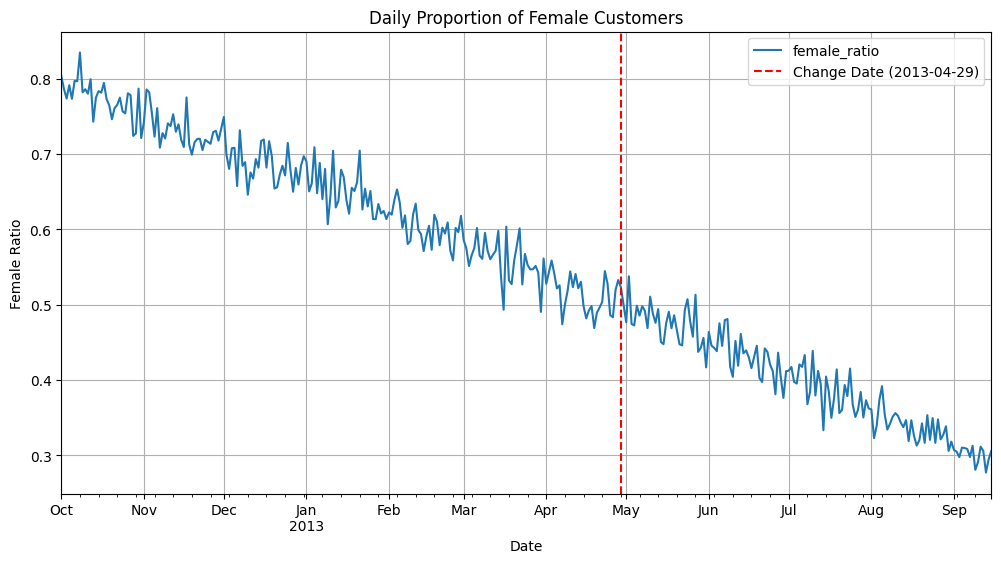

Mean female ratio before 2013-04-29: 0.6478
Mean female ratio after 2013-04-29: 0.3979


In [5]:
# Calculate daily gender counts
daily_gender_counts = frame.groupby([frame['sale_time'].dt.date, 'purchaser_gender']).size().unstack(fill_value=0)

# Calculate proportion of females
daily_gender_counts['total'] = daily_gender_counts['female'] + daily_gender_counts['male']
daily_gender_counts['female_ratio'] = daily_gender_counts['female'] / daily_gender_counts['total']

# Convert index to datetime for plotting
daily_gender_counts.index = pd.to_datetime(daily_gender_counts.index)

# Plot
plt.figure(figsize=(12, 6))
daily_gender_counts['female_ratio'].plot()
plt.axvline(pd.to_datetime('2013-04-29'), color='r', linestyle='--', label='Change Date (2013-04-29)')
plt.title('Daily Proportion of Female Customers')
plt.xlabel('Date')
plt.ylabel('Female Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean ratios before and after
ratio_before = daily_gender_counts[daily_gender_counts.index < split_date]['female_ratio'].mean()
ratio_after = daily_gender_counts[daily_gender_counts.index >= split_date]['female_ratio'].mean()

print(f"Mean female ratio before {split_date.date()}: {ratio_before:.4f}")
print(f"Mean female ratio after {split_date.date()}: {ratio_after:.4f}")

In [7]:
# Define dayparts
def get_daypart(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

# Apply daypart function
frame['daypart'] = frame['sale_time'].dt.hour.apply(get_daypart)

# Calculate percentages
daypart_counts = frame['daypart'].value_counts(normalize=True) * 100

print("Percentage of sales in each daypart:")
print(daypart_counts)

Percentage of sales in each daypart:
daypart
afternoon    39.413397
morning      30.769005
evening      20.858517
night         8.959081
Name: proportion, dtype: float64
